In [8]:
import scipy.io as sio 
import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt 
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
import re

import imageio,os

mat = sio.loadmat('data/swiss_roll_data.mat')

## View the data of swiss roll

<Figure size 432x288 with 0 Axes>

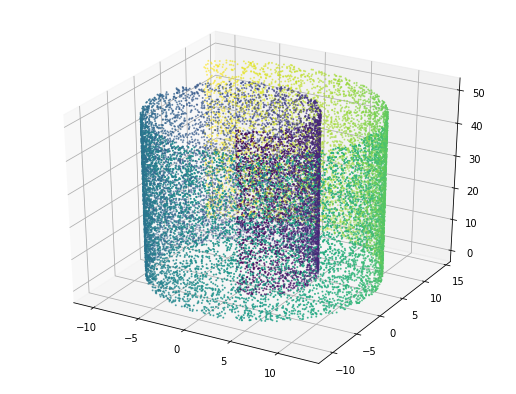

In [9]:

fig =plt.figure()
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(mat['X_data'].T[:,0],mat['X_data'].T[:,1],mat['X_data'].T[:,2],c = mat['Y_data'][0] ,s = 1)



## Igorne the 3rd dimension

<Figure size 432x288 with 0 Axes>

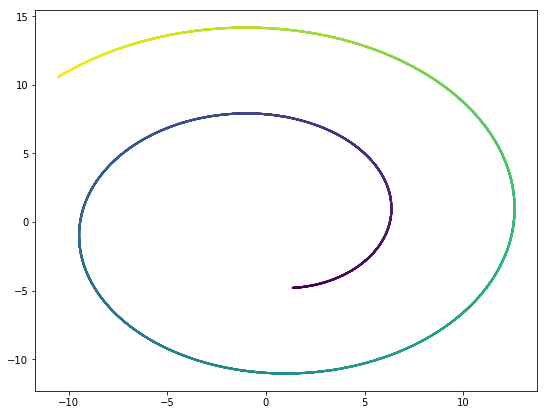

In [10]:
data_X = np.array([mat['X_data'].T[:,0],mat['X_data'].T[:,1]]).T
data_Y = np.array(mat['Y_data'][0])

fig =plt.figure()
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
ax.scatter(mat['X_data'].T[:,0],mat['X_data'].T[:,1],c = mat['Y_data'][0], s =1)


## Using PCA, reduce to 1 dimension

<Figure size 432x288 with 0 Axes>

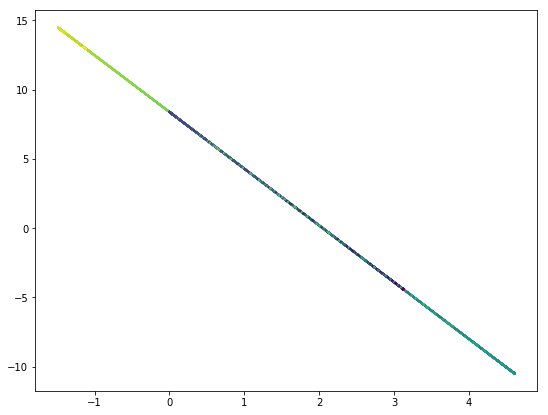

In [11]:
pca6 = PCA(n_components = 1)
lower_dimensional_data = pca6.fit_transform(data_X)
n_components6 = len(pca6.explained_variance_ratio_)
approximation6 = pca6.inverse_transform(lower_dimensional_data)
fig =plt.figure()
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
ax.scatter(approximation6[:,0],approximation6[:,1],c = mat['Y_data'][0],s = 1)


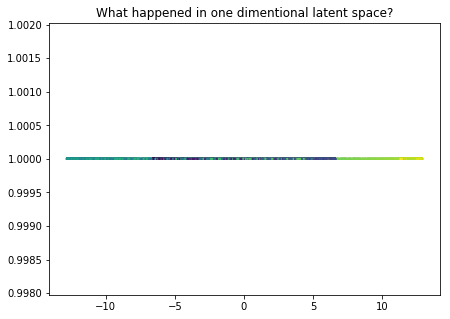

In [77]:
fig = plt.figure(figsize=(7,5))
plt.title('What happened in one dimentional latent space?')
plt.scatter(lower_dimensional_data, [1] * x_code.shape[0],c = mat['Y_data'][0] ,s = 1)

## Trainning an autoencoder for 360 epoch, try to reconstruct the swiss roll

In [68]:
import os
import torch
import torchvision
from torch import nn
import torch.utils.data as utils
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

# if not os.path.exists('./mlp_img'):
#     os.mkdir('./mlp_img')


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

dataroot = './data/'
resultroot = './result/'

Finalepoch = False
pretrain = False
num_epochs = 550
batch_size = 512
learning_rate = 1e-4
minloss = 1e7
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


tensor_x = torch.from_numpy(data_X) # transform to torch tensors
tensor_y =torch.from_numpy(data_Y)

my_dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
train_dataloader = utils.DataLoader(my_dataset,batch_size = batch_size,shuffle = True) # create your dataloader
test_dataloader = utils.DataLoader(my_dataset,batch_size = 20000,shuffle = True) # create your dataloader


In [69]:
class autoencoder(nn.Module):
    
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Linear(64, 32), 
            nn.ReLU(True), 
            nn.Linear(32, 8),
            nn.ReLU(True),
            nn.Linear(8, 1))
        self.decoder = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(True),
            nn.Linear(8, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 256),
            nn.ReLU(True), 
            nn.Linear(256, 2))

    def forward(self, x):
        x = self.encoder(x)
        if Finalepoch:
            np.save(resultroot + 'finallatent_space',x.data.numpy())
        x = self.decoder(x)
        return x
    
    




model = autoencoder()

if pretrain == True:
    model = torch.load('model/model1.pt')

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate*2, weight_decay=1e-4)

for epoch in range(num_epochs):
    # ===================test&plot========================
    if epoch % 3 == 0:
        for data in test_dataloader:

            testimg, y = data
            testimg = testimg.view(testimg.size(0), -1)
            testimg = Variable(testimg).float()
            testoutput = model(testimg.float())
            testloss = criterion(testoutput, testimg)
            print('Error in all data:epoch [{}/{}], loss:{:.4f}'
              .format(epoch + 1, num_epochs, testloss.data.item()))
            
            approximation = testoutput.detach().numpy()
            
            fig = plt.figure(figsize=(9,7))
            plt.scatter(approximation[:,0],approximation[:,1],c = y,s = 1)
            plt.title('After ' + str(epoch) + ' epochs')
            fig.savefig('images/' + str(epoch)+'.png')
            
            plt.close()
            break
    
    for data in train_dataloader:
        
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).float()
        # ===================forward=====================
        output = model(img.float())
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    # ===================save========================
    if epoch % 10 == 0 and loss.data.item() < minloss:
        torch.save(model, 'model/'+ str(epoch) + str(loss.data.item())+'.pt')
        minloss = loss.data.item()



Finalepoch = True
# run to collect the FM
testoutput = model(testimg.float())



Error in all data:epoch [1/550], loss:61.3133


/anaconda3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Error in all data:epoch [4/550], loss:38.3811
Error in all data:epoch [7/550], loss:30.3125
Error in all data:epoch [10/550], loss:25.1933
Error in all data:epoch [13/550], loss:22.1135
Error in all data:epoch [16/550], loss:15.0020
Error in all data:epoch [19/550], loss:9.3149
Error in all data:epoch [22/550], loss:6.5163
Error in all data:epoch [25/550], loss:5.2661
Error in all data:epoch [28/550], loss:4.8346
Error in all data:epoch [31/550], loss:4.2545
Error in all data:epoch [34/550], loss:4.0770
Error in all data:epoch [37/550], loss:3.9639
Error in all data:epoch [40/550], loss:3.8242
Error in all data:epoch [43/550], loss:3.8199
Error in all data:epoch [46/550], loss:3.5681
Error in all data:epoch [49/550], loss:3.5398
Error in all data:epoch [52/550], loss:3.4797
Error in all data:epoch [55/550], loss:3.5179
Error in all data:epoch [58/550], loss:3.4285
Error in all data:epoch [61/550], loss:3.3890
Error in all data:epoch [64/550], loss:3.3138
Error in all data:epoch [67/550

Error in all data:epoch [529/550], loss:0.4913
Error in all data:epoch [532/550], loss:0.4003
Error in all data:epoch [535/550], loss:0.3004
Error in all data:epoch [538/550], loss:0.3604
Error in all data:epoch [541/550], loss:0.4567
Error in all data:epoch [544/550], loss:0.3486
Error in all data:epoch [547/550], loss:0.3415
Error in all data:epoch [550/550], loss:0.4378


## Analysis of latent space

In [70]:
x_code = np.load(resultroot + 'finallatent_space.npy').flatten()
y = y.data.numpy()


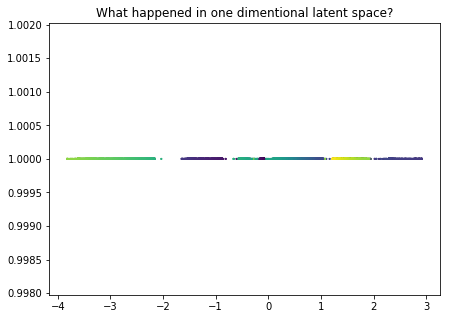

In [78]:
fig = plt.figure(figsize=(7,5))
plt.title('What happened in one dimentional latent space?')
plt.scatter(x_code, [1] * x_code.shape[0],c = y ,s = 1)

## Convert all .png image in to a .gif

In [72]:
os.chdir('images')
images = []
filenames=sorted((fn for fn in os.listdir('.') if fn.endswith('.png')),key=lambda x: int(re.sub('[a-z.]', '', x)))
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('gif.gif', images,duration=0.1)
os.chdir(os.path.dirname(os.getcwd()))

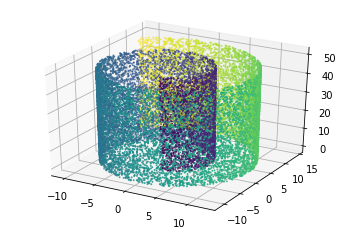

In [8]:
data_X = np.array([mat['X_data'].T[:,0],mat['X_data'].T[:,1]]).T
data_Y = np.array(mat['Y_data'][0])

fig =plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(mat['X_data'].T[:,0],mat['X_data'].T[:,1], mat['X_data'].T[:,2],c = mat['Y_data'][0], s =1)


In [16]:
data_X = np.array([mat['X_data'].T[:,0],mat['X_data'].T[:,1],mat['X_data'].T[:,2]]).T
data_Y = np.array(mat['Y_data'][0])

In [18]:

import os
import torch
import torchvision
from torch import nn
import torch.utils.data as utils
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

# if not os.path.exists('./mlp_img'):
#     os.mkdir('./mlp_img')


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

pretrain = False
num_epochs = 400
batch_size = 512
learning_rate = 1e-3
minloss = 1e7
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


tensor_x = torch.from_numpy(data_X) # transform to torch tensors
tensor_y =torch.from_numpy(data_Y)

my_dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
train_dataloader = utils.DataLoader(my_dataset,batch_size = batch_size,shuffle = True) # create your dataloader
test_dataloader = utils.DataLoader(my_dataset,batch_size = 20000,shuffle = True) # create your dataloader



class autoencoder(nn.Module):
    
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Linear(64, 32), 
            nn.ReLU(True), 
            nn.Linear(32, 8),
            nn.ReLU(True),
            nn.Linear(8, 2))
        self.decoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(True),
            nn.Linear(8, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 256),
            nn.ReLU(True), 
            nn.Linear(256, 3))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x


model = autoencoder()

if pretrain == True:
    model = torch.load('model/model1.pt')

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate*2, weight_decay=1e-4)

for epoch in range(num_epochs):
    # ===================test&plot========================
    if epoch % 3 == 0:
        for data in test_dataloader:

            testimg, y = data
            testimg = testimg.view(testimg.size(0), -1)
            testimg = Variable(testimg).float()
            testoutput = model(testimg.float())
            testloss = criterion(testoutput, testimg)
            print('Error in all data:epoch [{}/{}], loss:{:.4f}'
              .format(epoch + 1, num_epochs, testloss.data.item()))
            
            approximation = testoutput.detach().numpy()
            
            fig = plt.figure(figsize=(9,7))
            ax = fig.add_subplot(111,projection = '3d')
            ax.scatter(approximation[:,0],approximation[:,1],approximation[:,2],c = y,s = 1)
            plt.title('After ' + str(epoch) + ' epochs')
            fig.savefig('images3d/' + str(epoch)+'.png')
            
            plt.close()


            break
    
    for data in train_dataloader:
        
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).float()
        # ===================forward=====================
        output = model(img.float())
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
    # ===================log========================
    # print('epoch [{}/{}], loss:{:.4f}'
    #      .format(epoch + 1, num_epochs, loss.data.item()))
    
    # ===================save========================
    if epoch % 10 == 0 and loss.data.item() < minloss:
        torch.save(model, 'model/'+ str(epoch) + str(loss.data.item())+'.pt')
        minloss = loss.data.item()

torch.save(model.state_dict(), './sim_autoencoder.pth')

Error in all data:epoch [1/400], loss:319.1301


/anaconda3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Error in all data:epoch [4/400], loss:39.3288
Error in all data:epoch [7/400], loss:16.7991
Error in all data:epoch [10/400], loss:11.4351
Error in all data:epoch [13/400], loss:7.6698
Error in all data:epoch [16/400], loss:6.2341
Error in all data:epoch [19/400], loss:3.7981
Error in all data:epoch [22/400], loss:6.3936
Error in all data:epoch [25/400], loss:2.7781
Error in all data:epoch [28/400], loss:2.7120
Error in all data:epoch [31/400], loss:2.6408
Error in all data:epoch [34/400], loss:2.3615
Error in all data:epoch [37/400], loss:2.5855
Error in all data:epoch [40/400], loss:2.5062
Error in all data:epoch [43/400], loss:2.3144
Error in all data:epoch [46/400], loss:2.3385
Error in all data:epoch [49/400], loss:2.5509
Error in all data:epoch [52/400], loss:2.1169
Error in all data:epoch [55/400], loss:2.4165
Error in all data:epoch [58/400], loss:8.6343
Error in all data:epoch [61/400], loss:2.4475
Error in all data:epoch [64/400], loss:2.1657
Error in all data:epoch [67/400],

In [21]:
os.chdir('images3d')
images = []
filenames=sorted((fn for fn in os.listdir('.') if fn.endswith('.png')),key=lambda x: int(re.sub('[a-z.]', '', x)))
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('gif.gif', images,duration=0.1)
os.chdir(os.path.dirname(os.getcwd()))